# Benjamin Lavoie (benjaminlavoie02@gmail.com)

# CapStone project: Gaming Score Forecasting Model

# Last update: March 15th, 2024 (version 2.1)

# Notebook 2: Pre-processing and Processing

# Table of Contents

**[3. Part 3 - Introduction (2nd Notebook)](#heading--3)**

  * [3.1 - Data Dictionary](#heading--3-1)

  * [3.2 - Separating the dataframe](#heading--3-2)

  * [3.3 - One hot encoding (dummy variables)](#heading--3-3)
  
  * [3.4 - Columns to vectorize with TFDIF](#heading--3-4)
    
  * [3.5 - Variance Threshold](#heading--3-5)
  

**[4. Part 4 - Modeling](#heading--4)**
  
  * [4.1 - First Scores, some optimization](#heading--4-1)
  
  * [4.2 - Confusion Matrix](#heading--4-2)
  

In [4]:

# Necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import nltk
import statsmodels.api as sm
import glob
import os
from scipy.stats import chi2_contingency


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# To plot
from scipy import stats
from scipy.stats import norm 

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To process text data
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To cross-validate
from sklearn.model_selection import cross_val_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To do dimensionality reduction
from sklearn.decomposition import PCA

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold



#imporint different models

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


# To see more columns at once, I'll change the display.max_columns number
pd.set_option('display.max_columns', 50)

<div id="heading--3"/>

## 3. Part 3 - Introduction (2nd Notebook)

The cleaning and the EDA has all been done in the 1st Notebook.

In this 2nd Notebook, I will be doing the pre-processing as well as the processing/modeling.

I will start importing the data set, and then by separating the dataset. Since I have 14k+ rows and not 100k+ rows, I'll keep only 20% for the testing.

<div id="heading--3-1"/>

## 3.1 - Data Dictionary:

| Feature/Column | Definition | Data type |
|----------|----------|----------|
| Platform | Platform the game was released on | String |
| Developer | Developer of the game | String |
| Publisher | Publisher of the game | String |
| Genre | Genre of the game | String |
| Platform_Brand | Brand of the platform (Nintendo, Sony, Microsoft, PC | String |
| Platform_Type | Type of the platform (HomeConsole, Handheld, PC) | String |
| Release Date | Release date | DateTime |
| Metascore_Range | Classification: Weak, Okay or Strong | String |

In [5]:
df = pd.read_csv('clean_data_2.0.csv', index_col='Unnamed: 0', header=0)

In [6]:
df.head(5)

Name Platform   Publisher            Developer  \
0                        Wii Sports      Wii  Nintendo         Nintendo EAD     
1               Mario Kart 8 Deluxe       NS  Nintendo         Nintendo EPD     
2                   Team Fortress 2       PC     Valve    Valve Corporation     
3  Counter-Strike: Global Offensive       PC     Valve    Valve Corporation     
4  Counter-Strike: Global Offensive       PC     Valve    Valve Corporation     

     Genre Platform_Brand Platform_Type Release_Date  Release_Day  \
0   Sports       Nintendo   HomeConsole   2006-11-19           19   
1   Racing       Nintendo   HomeConsole   2017-04-28           28   
2  Shooter             PC            PC   2007-10-10           10   
3  Shooter             PC            PC   2012-08-21           21   
4  Shooter             PC            PC   2015-10-23           23   

   Release_Month  Release_Year Metascore_Range  
0             11          2006            Okay  
1              4          2017          Strong  
2             10          2007          Strong  
3              8          2012          Strong  
4             10          2015          Strong

<div id="heading--3-2"/>

## 3.2 - Separating the dataframe

Let's separate the data in train and test sets.

In [7]:
df.drop(['Platform', 'Release_Date', 'Release_Day','Release_Month', 'Release_Year'], axis = 1, inplace=True)
# df.drop(['Release_Date', 'Release_Day','Release_Month', 'Release_Year'], axis = 1, inplace=True)

In [8]:
# separating into X and y

X = df.drop(columns="Metascore_Range")
y = df["Metascore_Range"]


# Separating into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

# resetting the indexes to be able to separate the review columns and concatenate them easily later
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


# Print info on how the data has been split
print(f'The TRAIN set has {len(X_train)} data points.')
print(f'The TEST set has {len(X_test)} data points.')

The TRAIN set has 12221 data points.
The TEST set has 2157 data points.


In [9]:
# might use later

# for col1 in X_train.columns:
#     for col2 in X_train.columns:
#         if col1 != col2:
#             contingency_table = pd.crosstab(X_train[col1], X_train[col2])
#             chi2, p, _, _ = chi2_contingency(contingency_table)
#             if (p > 1e-10):
#                 print(f'Chi-square test between {col1} and {col2}: Chi2={chi2}, p-value={p}')

<div id="heading--3-3"/>

## 3.3 - One hot encoding (dummy variables)

<br>

I will transform some of the columns into dummy variables
- Platform (testing with and without)
- Genre
- Platform_Brand
- Platform_Type

In [10]:
# when trying without platform

# X_train_numerical = X_train[['Platform', 'Genre', 'Platform_Brand', 'Platform_Type']].copy()
# X_train_dummy = pd.get_dummies(X_train_numerical, dtype=np.int32)

# X_test_numerical = X_test[['Platform', 'Genre', 'Platform_Brand', 'Platform_Type']].copy()
# X_test_dummy = pd.get_dummies(X_test_numerical, dtype=np.int32)

# X_train = pd.concat([X_train, X_train_dummy], axis="columns")
# X_test = pd.concat([X_test, X_test_dummy], axis="columns")

# X_train.drop(['Platform', 'Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)
# X_test.drop(['Platform', 'Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)




X_train_numerical = X_train[['Genre', 'Platform_Brand', 'Platform_Type']].copy()
X_train_dummy = pd.get_dummies(X_train_numerical, dtype=np.int32)

X_test_numerical = X_test[['Genre', 'Platform_Brand', 'Platform_Type']].copy()
X_test_dummy = pd.get_dummies(X_test_numerical, dtype=np.int32)

X_train = pd.concat([X_train, X_train_dummy], axis="columns")
X_test = pd.concat([X_test, X_test_dummy], axis="columns")


X_train.drop(['Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)
X_test.drop(['Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)


In [11]:
# sanity check with all the dfs

print(X_train_numerical.shape)
print(X_train_dummy.shape)
print(X_test_numerical.shape)
print(X_test_dummy.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())

(12221, 3)
(12221, 26)
(2157, 3)
(2157, 26)
(12221, 29)
(2157, 29)
0
0


In [12]:
# checking the columns

X_train.columns

Index(['Name', 'Publisher', 'Developer', 'Genre_Action',
       'Genre_Action-Adventure', 'Genre_Adventure', 'Genre_Board Game',
       'Genre_Fighting', 'Genre_MMO', 'Genre_Misc', 'Genre_Music',
       'Genre_Party', 'Genre_Platform', 'Genre_Puzzle', 'Genre_Racing',
       'Genre_Role-Playing', 'Genre_Sandbox', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy',
       'Genre_Visual Novel', 'Platform_Brand_Microsoft',
       'Platform_Brand_Nintendo', 'Platform_Brand_PC', 'Platform_Brand_Sony',
       'Platform_Type_Handheld', 'Platform_Type_HomeConsole',
       'Platform_Type_PC'],
      dtype='object')

I think that using a NLP is a good idea, so I will use TF IDF to create more features. Then, I will be able to continue the processing.

<div id="heading--3-4"/>

## 3.4 - Columns to vectorize with TFDIF

Before vectorizing, I will create a my_tokenizer function to tokenize properly some columns

In [13]:
stemmer = nltk.stem.PorterStemmer()

ENGLISH_STOP_WORDS = stopwords.words('english')

# Custom stopwords to be added

custom_stopwords = []
# custom_stopwords = ['game', 'games', 'unknown', 'studio', 'inc', 'ltd', 'studios']

# Extend stopwords with custom stopwords
ENGLISH_STOP_WORDS.extend(custom_stopwords)

# my_tokenizer function, to be used when vectorizing
def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

Now, I will vectorize 3 columns: Name, Publisher and Developer.

Under the code, I will also create histograms to show the 20 most weighted words in each column.

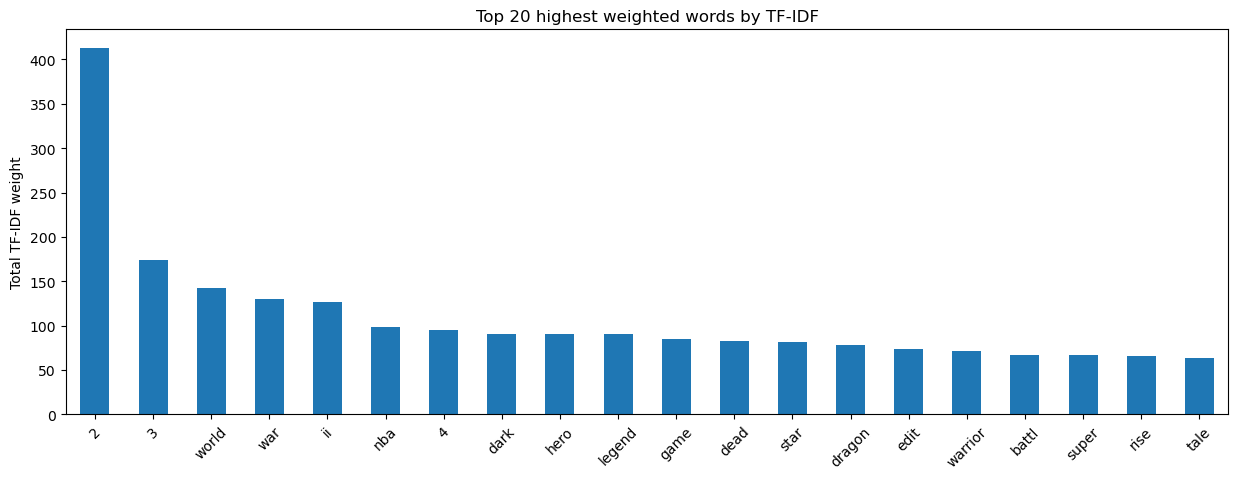

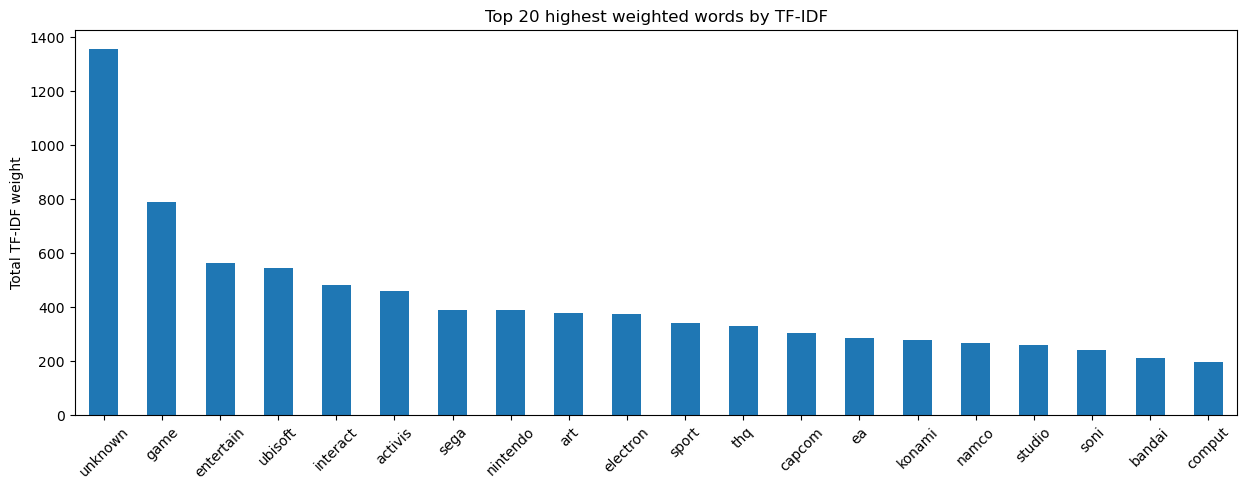

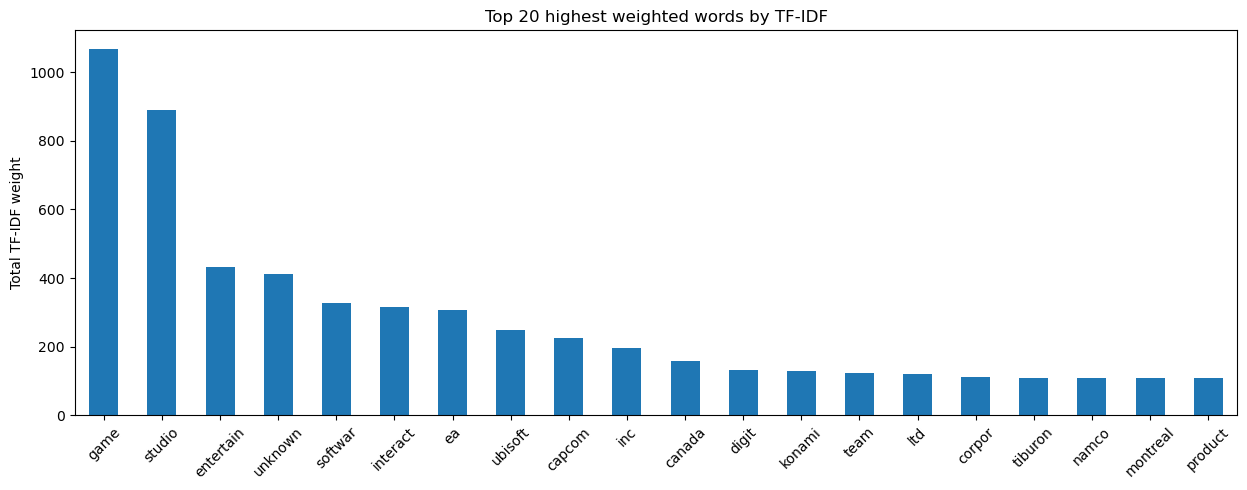

0
0
(12221, 1383)
(2157, 1383)


In [14]:
tfidf_columns = ['Name', 'Publisher', 'Developer']

tfidf_dfs = []
X_train_keep = pd.DataFrame()

for col in tfidf_columns:

    tfidf = TfidfVectorizer(tokenizer = my_tokenizer, min_df=10)

    # Fit and transform the text data
    transformed_train = tfidf.fit_transform(X_train[col])
    transformed_test = tfidf.transform(X_test[col])
    
    # store my vectorizers
    tfidf_dfs.append(tfidf)

    # Convert the transformed data into a dataframe
    tfidf_df_train = pd.DataFrame(transformed_train.toarray(),
                                   columns=tfidf.get_feature_names_out())

    tfidf_df_test = pd.DataFrame(transformed_test.toarray(),
                                   columns=tfidf.get_feature_names_out())


    # Join the 2 tfidf_df with the 2 dfs
    tfidf_df_train = tfidf_df_train.add_prefix(f'{col}_')
    tfidf_df_test = tfidf_df_test.add_prefix(f'{col}_')
    X_train = pd.concat([X_train, tfidf_df_train], axis="columns")
    X_test = pd.concat([X_test, tfidf_df_test], axis="columns")
    
    X_train_keep[col] = X_train[col]
    
    X_train.drop(col, axis = 1, inplace=True)
    X_test.drop(col, axis = 1, inplace=True)
    
    word_counts = pd.DataFrame(
        {"counts": transformed_train.toarray().sum(axis=0)},
        index=tfidf.get_feature_names_out()
    ).sort_values("counts", ascending=False)

    word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title("Top 20 highest weighted words by TF-IDF")
    plt.ylabel("Total TF-IDF weight")
    plt.xticks(rotation=45)
    plt.show()

# checking for null values and the shapes
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(X_train.shape)
print(X_test.shape)

In [15]:
# sanity check

X_train.head()

Genre_Action  Genre_Action-Adventure  Genre_Adventure  Genre_Board Game  \
0             0                       0                0                 0   
1             0                       0                0                 0   
2             0                       0                0                 0   
3             0                       0                0                 0   
4             0                       0                0                 0   

   Genre_Fighting  Genre_MMO  Genre_Misc  Genre_Music  Genre_Party  \
0               0          0           0            0            0   
1               0          0           0            0            0   
2               0          0           1            0            0   
3               0          0           0            0            0   
4               0          0           0            0            0   

   Genre_Platform  Genre_Puzzle  Genre_Racing  Genre_Role-Playing  \
0               0             0             0                   0   
1               0             0             1                   0   
2               0             0             0                   0   
3               0             0             0                   0   
4               0             0             0                   1   

   Genre_Sandbox  Genre_Shooter  Genre_Simulation  Genre_Sports  \
0              0              0                 0             1   
1              0              0                 0             0   
2              0              0                 0             0   
3              0              0                 0             0   
4              0              0                 0             0   

   Genre_Strategy  Genre_Visual Novel  Platform_Brand_Microsoft  \
0               0                   0                         0   
1               0                   0                         0   
2               0                   0                         0   
3               1                   0                         0   
4               0                   0                         0   

   Platform_Brand_Nintendo  Platform_Brand_PC  Platform_Brand_Sony  \
0                        0                  0                    1   
1                        0                  0                    1   
2                        0                  1                    0   
3                        0                  1                    0   
4                        0                  0                    1   

   Platform_Type_Handheld  Platform_Type_HomeConsole  ...  Developer_unknown  \
0                       0                          1  ...                0.0   
1                       0                          1  ...                0.0   
2                       0                          0  ...                1.0   
3                       0                          0  ...                0.0   
4                       0                          1  ...                0.0   

   Developer_unlimit  Developer_valv  Developer_vancouv  Developer_vanillawar  \
0                0.0             0.0                0.0                   0.0   
1                0.0             0.0                0.0                   0.0   
2                0.0             0.0                0.0                   0.0   
3                0.0             0.0                0.0                   0.0   
4                0.0             0.0                0.0                   0.0   

   Developer_vicari  Developer_viciou  Developer_view  Developer_viscer  \
0               0.0               0.0             0.0               0.0   
1               0.0               0.0             0.0               0.0   
2               0.0               0.0             0.0               0.0   
3               0.0               0.0             0.0               0.0   
4               0.0               0.0             0.0               0.0   

   Developer_vision  Developer_visual  Developer_vol

In [16]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12221 entries, 0 to 12220
Columns: 1383 entries, Genre_Action to Developer_zoink
dtypes: float64(1357), int32(26)
memory usage: 127.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Columns: 1383 entries, Genre_Action to Developer_zoink
dtypes: float64(1357), int32(26)
memory usage: 22.5 MB
None


Before modeling, dropping one last column:

In [17]:
# dopping at the beginning, keeping this if needed

# X_train.drop('Release_Date', axis = 1, inplace=True)
# X_test.drop('Release_Date', axis = 1, inplace=True)


<div id="heading--3-5"/>

## 3.5 - Variance Threshold


With the variance threshold, I will only keep values that have a variance over the threshold. This way, all the columns that I don't need can be removed.

In [18]:
# setting the threshold

threshold_value = 0.001
selector = VarianceThreshold(threshold=threshold_value)

# Fit and transform the selector to X_train
X_selected = selector.fit_transform(X_train)

# Get the support mask
support_mask = selector.get_support()

# Get the indices of features to keep
indices_to_keep = [i for i, support in enumerate(support_mask) if support]

# Print the indices of features to keep
print("Indices of features to keep:", indices_to_keep)

X_train = X_train.iloc[:,indices_to_keep]
X_test = X_test.iloc[:,indices_to_keep]

Indices of features to keep: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 39, 41, 42, 43, 44, 45, 46, 47, 66, 67, 68, 70, 73, 77, 78, 79, 83, 85, 96, 100, 104, 105, 117, 118, 120, 122, 123, 124, 128, 129, 131, 132, 139, 145, 149, 159, 161, 169, 170, 171, 172, 176, 178, 180, 183, 186, 187, 189, 192, 193, 205, 207, 209, 216, 218, 220, 223, 224, 227, 229, 236, 238, 244, 248, 251, 253, 257, 258, 260, 261, 262, 265, 266, 268, 270, 273, 274, 277, 279, 284, 288, 289, 294, 298, 300, 302, 304, 308, 311, 312, 313, 315, 316, 323, 324, 332, 336, 341, 344, 345, 348, 352, 354, 355, 363, 364, 367, 369, 370, 371, 374, 379, 381, 390, 392, 393, 394, 398, 401, 402, 403, 416, 417, 419, 426, 427, 429, 430, 432, 434, 435, 438, 439, 441, 442, 443, 444, 445, 447, 449, 451, 455, 457, 459, 460, 464, 467, 468, 470, 481, 482, 484, 490, 499, 501, 502, 504, 509, 512, 513, 514, 516, 519, 523, 525, 528, 530, 536, 538, 540, 545, 551, 552, 556, 559, 560, 563, 564, 

In [19]:
# sanity check to confirm the number of columns

print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12221 entries, 0 to 12220
Columns: 608 entries, Genre_Action to Developer_yuke
dtypes: float64(584), int32(24)
memory usage: 55.6 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2157 entries, 0 to 2156
Columns: 608 entries, Genre_Action to Developer_yuke
dtypes: float64(584), int32(24)
memory usage: 9.8 MB
None


Because I removed a lot of columns, it created duplicated rows. So I will check where they are and remove them in both the X and y, train and test dfs.

In [20]:
# checking the number of duplicated rows

print(X_train.duplicated().sum())
print(X_test.duplicated().sum())

1229
62


In [21]:
# dropping the duplicated rows on all the dfs

# list of indices of the duplicated rows in X_train
duplicate_indices = X_train[X_train.duplicated()].index

# Remove duplicate rows from X_train
X_train = X_train.drop_duplicates()

# Remove corresponding rows from y_train
y_train = y_train.drop(index=duplicate_indices)


# list of indices of the duplicated rows in X_test
duplicate_indices = X_test[X_test.duplicated()].index

# Remove duplicate rows from X_test
X_test = X_test.drop_duplicates()

# Remove corresponding rows from y_test
y_test = y_test.drop(index=duplicate_indices)

<div id="heading--4"/>

## 4. Part 4 - Modeling

<br>

I will start the modeling with different models at first.

I will also store the test scores in the df_scores dataframe.

### This part is still under construction. Some cells are work in progress.

In [22]:
# instantiating df_scores to store scores

df_scores=pd.DataFrame(columns=['score'])

df_scores

Empty DataFrame
Columns: [score]
Index: []

In [23]:
%%time

# Baseline logistic regression

# Instantiate and fit to the train
baseline_logreg = LogisticRegression(max_iter = 5000, n_jobs=-1).fit(X_train, y_train)


# Print the accuracies
print(f'Accuracy on test set: {baseline_logreg.score(X_test, y_test)}')

df_scores.loc[f"Baseline log reg : C={baseline_logreg.get_params()['C']}"]=round(baseline_logreg.score(X_test, y_test),3)
df_scores

Accuracy on test set: 0.5202863961813843
CPU times: user 246 ms, sys: 317 ms, total: 562 ms
Wall time: 5.51 s


score
Baseline log reg : C=1.0   0.52

In [24]:
# Set up a directory to cache the pipeline results - if the same step with the same parameters is called again,
# the cached result is used instead of re-computing it.
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline(steps=[
                        ('scaler', StandardScaler()),
                        ('dim_reducer', PCA()),
                        ('model', LogisticRegression())],
                        memory=cachedir)

In [25]:
# testing the first pipeline

pipeline_test=my_pipeline.fit(X_train,y_train)
pipeline_test

Pipeline(memory='/var/folders/78/w0cjxhcs0bs0nxt9vj1kv61m0000gn/T/tmpcadbuzo0',
         steps=[('scaler', StandardScaler()), ('dim_reducer', PCA()),
                ('model', LogisticRegression())])

In [26]:
# storing the pipeline_test score in the df_scores

pipeline_test.score(X_test,y_test)
df_scores.loc[f"pipeline_test: "]=round(baseline_logreg.score(X_test, y_test),3)

In [27]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the test data using the scaler fitted on the training data
X_test = scaler.transform(X_test)


In [28]:
# work in progress

# 1. Instantiate model
videogames_rfc = RandomForestClassifier(max_depth = 5, max_features = 1000)

# 2. Fit model
videogames_rfc.fit(X_train, y_train);


print(f'Score on train: {videogames_rfc.score(X_train, y_train)}')
print(f'Score on test: {videogames_rfc.score(X_test, y_test)}')

df_scores.loc[f"RandomForestClassifier: "]=round(videogames_rfc.score(X_test, y_test),3)

Score on train: 0.45423944687045126
Score on test: 0.44009546539379474


In [29]:
# testing 6 different models, some have been optimized, some no
# work in progress

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_encoded,
#                                                     test_size=0.3, stratify = y_encoded)

xgb_model = XGBClassifier(colsample_bytree= 0.75,
                          learning_rate= 0.1, max_depth= 7,
                          n_estimators= 500, subsample= 1)
ab_model = AdaBoostClassifier()
rf_model = RandomForestClassifier(max_depth= None, max_features= 'sqrt',
                                  min_samples_leaf= 1, min_samples_split= 10, n_estimators= 300)
nn_model = MLPClassifier(hidden_layer_sizes=(5,5,5,5))
dtc_model = DecisionTreeClassifier()
bag_model = BaggingClassifier()

xgb_model.fit(X_train, y_train)
ab_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)
dtc_model.fit(X_train, y_train)
bag_model.fit(X_train, y_train)


print("Scores:")
print(f"AdaBoost train score : {ab_model.score(X_train, y_train)}")
print(f"AdaBoost test score: {ab_model.score(X_test, y_test)}")
print(f"Random Forest train score: {rf_model.score(X_train, y_train)}")
print(f"Random Forest test score: {rf_model.score(X_test, y_test)}")
print(f"XG Boost train score: {xgb_model.score(X_train, y_train)}")
print(f"XG Boost test score: {xgb_model.score(X_test, y_test)}")
print(f"NN Boost train score: {nn_model.score(X_train, y_train)}")
print(f"NN Boost test score: {nn_model.score(X_test, y_test)}")
print(f"DecisionTreeClassifier train score: {dtc_model.score(X_train, y_train)}")
print(f"DecisionTreeClassifier test score: {dtc_model.score(X_test, y_test)}")
print(f"BaggingClassifier train score: {bag_model.score(X_train, y_train)}")
print(f"BaggingClassifier test score: {bag_model.score(X_test, y_test)}")



df_scores.loc[f"AdaBoost: "]=round(ab_model.score(X_test, y_test),3)
df_scores.loc[f"Random Forest: "]=round(rf_model.score(X_test, y_test),3)
df_scores.loc[f"XG Boost: "]=round(xgb_model.score(X_test, y_test),3)
df_scores.loc[f"NN Boost: "]=round(nn_model.score(X_test, y_test),3)
df_scores.loc[f"DecisionTreeClassifier: "]=round(dtc_model.score(X_test, y_test),3)
df_scores.loc[f"BaggingClassifier: "]=round(bag_model.score(X_test, y_test),3)

Scores:
AdaBoost train score : 0.47006914119359533
AdaBoost test score: 0.45441527446300717
Random Forest train score: 0.9337700145560408
Random Forest test score: 0.5651551312649165
XG Boost train score: 0.7520924308588064
XG Boost test score: 0.5670644391408115
NN Boost train score: 0.712245269286754
NN Boost test score: 0.5088305489260143
DecisionTreeClassifier train score: 1.0
DecisionTreeClassifier test score: 0.49594272076372314
BaggingClassifier train score: 0.9757096069868996
BaggingClassifier test score: 0.5455847255369929


In [32]:
%%time

# work in progress, it takes a long time


param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Initialize GridSearchCV with the specified parameter grid and XGBoost model
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters:", grid_search.best_params_)

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Evaluate the best model on the test data
accuracy = best_xgb_model.score(X_test, y_test)
print("Test accuracy of best model:", accuracy)

df_scores.loc[f"Best XGB Model: "]=round(best_xgb_model.score(X_test, y_test),3)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.75; total time=   4.6s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  12.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=  20.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.75; total time=   5.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.75; total time=  14.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=  23.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.5; total time=  17.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=  28.6s
[CV] END cols

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   4.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=  12.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.75; total time=  20.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time=  14.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.5; total time=  23.6s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.75; total time=   6.6s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.75; total time=  17.7s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=1.0; total time=  28.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   4.8s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.75; total time=  12.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=  20.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=  14.6s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=  23.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.5; total time=  16.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.5; total time=  28.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=10

[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, n_estimators=300, subsample=0.5; total time=  20.5s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.75; total time=  33.7s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0; total time=   8.7s
[CV] END colsample_bytree=0.5, learning_rate=0.001, max_depth=7, n_estimators=300, subsample=1.0; total time=  25.8s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   6.6s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   7.3s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   7.0s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   6.4s
[CV] END colsample_bytree=0.75, learning_rate=0.1, max_depth=3, n_e

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.75; total time=   4.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=  11.8s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=  20.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=  14.7s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=1.0; total time=  23.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.5; total time=  16.8s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=500, subsample=0.75; total time=  29.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   4.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.75; total time=  12.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   5.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   5.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=   5.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.75; total time=   5.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.75; total time=  15.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=500, subsample=0.75; total time=  23.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   5.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=  11.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.75; total time=  20.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   5.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=  15.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   6.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   6.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5; total time=   6.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=100

[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=300, subsample=1.0; total time=  24.4s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=500, subsample=1.0; total time=  34.9s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=300, subsample=0.75; total time=  26.9s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.75; total time=  43.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  17.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=  26.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.75; total time=   8.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.75; total time=  19.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n

In [867]:
# work in progress, it takes a long time

%%time

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize Random Forest classifier
rf_model = RandomForestClassifier()

# Initialize GridSearchCV with the specified parameter grid and Random Forest model
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters:", grid_search.best_params_)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test data
accuracy = best_rf_model.score(X_test, y_test)
print("Test accuracy of best model:", accuracy)

df_scores.loc[f"Best RF Model: "]=round(best_rf_model.score(X_test, y_test),3)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


KeyboardInterrupt: 

In [868]:
# work in progress, it takes a long time

# Let's try the same range of C values from earlier
c_values = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

# Parameter grid
logreg_param_grid = [

    # l1 with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(solver='saga',penalty='l1', random_state=1, n_jobs=-1, max_iter=1000)],
     'model__C': c_values},


    # l2 (default) with PCA
    {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
     'dim_reducer': [PCA()],
     'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
     'model': [LogisticRegression(penalty='l2',random_state=1, n_jobs=-1, max_iter=1000)],
     'model__C': c_values}
]

In [ ]:
# work in progress, it takes a long time

%%time

# Instantiate the log reg grid search
logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=3)

# Fit the log reg grid search
logreg_gs.fit(X_train, y_train)

print(f"The best logistic regression's accuracy on the train set: {logreg_gs.score(X_train, y_train)}")
print(f"The best logistic regression's accuracy on the test set: {logreg_gs.score(X_test, y_test)}")

df_scores.loc[f"LogReg_GS Model: "]=round(logreg_gs.score(X_test, y_test),3)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


python(22009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22010) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22011) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22012) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22013) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22014) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22016) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(22019) Malloc

<div id="heading--4-1"/>

## 4.1 - First Scores, some optimization

<br>

In [33]:
# showing all the scores

df_scores


score
Baseline log reg : C=1.0  0.520
pipeline_test:            0.520
RandomForestClassifier:   0.440
AdaBoost:                 0.454
Random Forest:            0.565
XG Boost:                 0.567
NN Boost:                 0.509
DecisionTreeClassifier:   0.496
BaggingClassifier:        0.546
Best XGB Model:           0.569

<div id="heading--4-2"/>

## 4.2 - Confusion Matrix

<br>

In [34]:
# quick test of confusion matrix

# Get class predictions
y_pred = best_xgb_model.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predict 1", "2", "3"],
    index=["True 1", "2", "3"]
)

display(cf_df)

Predict 1    2    3
True 1        307  168  211
2             153  417  124
3             167   80  468

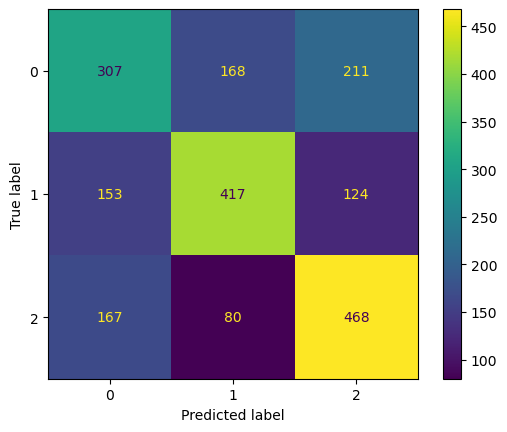

In [35]:
ConfusionMatrixDisplay.from_estimator(best_xgb_model, X_test, y_test)

In [36]:
print(f'The current best accuracy with XG Boost is : {round(best_xgb_model.score(X_test, y_test),3)}')

The current best accuracy with XG Boost is : 0.569
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=300, subsample=0.5; total time=  21.8s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.5; total time=  35.6s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.75; total time=   9.2s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=300, subsample=0.75; total time=  26.5s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.75; total time=  43.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.75; total time=  17.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.75; total time=  26.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.75; total time=   9.1s
[CV] END

[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=300, subsample=0.5; total time=  21.6s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.75; total time=  36.6s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0; total time=   9.2s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=300, subsample=1.0; total time=  28.3s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0; total time=  42.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.75; total time=  17.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=  25.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time=  20.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, 

[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=300, subsample=0.5; total time=  22.1s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.5; total time=  35.1s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.75; total time=   9.3s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=300, subsample=0.75; total time=  27.8s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=500, subsample=1.0; total time=  45.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0; total time=  16.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=1.0; total time=  26.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time=  20.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, 

[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=300, subsample=1.0; total time=  23.6s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5; total time=   9.4s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5; total time=   9.9s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5; total time=   9.5s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.75; total time=   9.1s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=300, subsample=0.75; total time=  25.6s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.75; total time=  41.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  17.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_de

[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=300, subsample=0.5; total time=  22.1s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.5; total time=  34.4s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.75; total time=   9.6s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=300, subsample=0.75; total time=  26.3s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.75; total time=  42.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  17.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=500, subsample=0.5; total time=  27.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   9.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5,

[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=100, subsample=1.0; total time=   7.6s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=5, n_estimators=500, subsample=0.5; total time=  36.3s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5; total time=   9.8s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5; total time=   9.0s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=300, subsample=0.5; total time=  26.1s
[CV] END colsample_bytree=0.75, learning_rate=0.001, max_depth=7, n_estimators=500, subsample=0.5; total time=  41.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.75; total time=   6.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  17.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3

## The models are just a first draft of what it can do, I haven't optimized a lot yet.

## More to follow